In [1]:
import numpy as np
import pandas as pd
import glob
import torch
import clip
from PIL import Image

In [23]:
path = './'
documents = ['photos']
datasets = {}

for doc in documents:
  files = glob.glob(path + doc + ".tsv*")

  subsets = []
  for filename in files:
    df = pd.read_csv(filename, sep='\t', header=0)
    subsets.append(df)

  datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

In [ ]:
datasets['photos'].head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,wud-eV6Vpwo,https://unsplash.com/photos/wud-eV6Vpwo,https://images.unsplash.com/photo-143924685475...,2015-08-10 22:48:30.841999,t,4273,2392,1.79,NaN,sergio_rola,...,NaN,NaN,7515660,42055,silhouette of structure under red sky,NaN,NaN,NaN,NaN,LJMymdi{1IWo}Gj[w^WVICS#bbS2
1,psIMdj26lgw,https://unsplash.com/photos/psIMdj26lgw,https://images.unsplash.com/photo-144077331099...,2015-08-28 14:49:40.016052,t,3872,2176,1.78,NaN,xcvii,...,NaN,NaN,1814817,5893,selective focus photography of black animal ne...,NaN,NaN,NaN,NaN,"LKKd}R^,bJD%~q4Txu%N%gxuD$xu"
2,2EDjes2hlZo,https://unsplash.com/photos/2EDjes2hlZo,https://images.unsplash.com/photo-144683489809...,2015-11-06 18:36:17.334458,t,2560,1707,1.50,Sunset reflection over river,imthinhvu,...,NaN,NaN,2708347,12420,photo of body body of water during golden hour,NaN,NaN,NaN,NaN,LeI{]g9u9u%1?KV@s8R-EAf#t5aL
3,WN8kSLy8KMQ,https://unsplash.com/photos/WN8kSLy8KMQ,https://images.unsplash.com/photo-144530812443...,2015-10-20 02:29:20.267471,t,2288,1520,1.51,Hiking The Mountains,bettenz,...,NaN,NaN,1616448,9773,green leafed trees between two rock formations,Zion National Park,37.250981,-112.950525,65.07215,LoDv=$sjD$bc.AV@ROWCtSn~s:Rj
4,QAXDmkU60OU,https://unsplash.com/photos/QAXDmkU60OU,https://images.unsplash.com/photo-144196149785...,2015-09-11 08:51:54.202624,t,2048,1371,1.49,NaN,j,...,NaN,NaN,983884,9410,landscape photography of snow covered mountain...,NaN,NaN,NaN,NaN,LUIPMT9F%LoIBax]Rkj]Aet7Rjj[


In [4]:
import requests
from io import BytesIO
from PIL import Image
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load("ViT-B/32", device=device)

urls = datasets['photos']['photo_image_url']
batch_size = 128
all_img_features = []

for i in tqdm(range(0, len(urls), batch_size)):
  img_input = []
  urls_batch = urls[i:i+batch_size]
  for url in urls_batch:
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      img_preprocessed = preprocess(img).unsqueeze(0).to(device)
      del img, response
    except:
      img_preprocessed = torch.randn((1,3,224,224), dtype=torch.float32, device=device)
    img_input.append(img_preprocessed)
  img_input = torch.cat(img_input, 0)
  with torch.no_grad():
    img_features = model.encode_image(img_input).cpu().numpy()
    all_img_features.append(img_features)

all_img_features = np.concatenate(all_img_features)
print(all_img_features.shape)
np.savez('img_features_CLIP.npz', all_img_features)

cpu


  1%|          | 2/196 [02:22<3:53:36, 72.25s/it]/opt/homebrew/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (107424768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  4%|▍         | 8/196 [10:36<4:15:24, 81.52s/it]/opt/homebrew/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 24%|██▍       | 48/196 [1:03:24<3:21:42, 81.77s/it]/opt/homebrew/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (112211825 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 25%|██▌       | 49/196 [1:04:37<3:13:27, 78.96s/it]/opt/homebrew/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (94212096 pixels) exceeds limit of 89478485 pixels, could be decompressio

(25000, 512)


In [6]:
img_features = torch.tensor(np.load('img_features_CLIP.npz')['arr_0'])
img_features.shape

torch.Size([25000, 512])

In [56]:
def cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.

    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1)).reshape(-1)

def get_similar_images(img_features, query, k=5):
  text = clip.tokenize([query]).to(device)
  with torch.no_grad():
    text_features = model.encode_text(text).float()
    similarity = cos_sim(img_features, text_features)
  values, indices = torch.topk(similarity, k)
  print(indices, values)
  indices = indices.cpu().numpy()
  urls = datasets['photos']['photo_image_url'].iloc[indices]
  asp_ratios = datasets['photos']['photo_aspect_ratio'].iloc[indices]
  photo_ids = datasets['photos'].iloc[indices].photo_id.to_numpy()
  for photo_id in photo_ids:
    kws = datasets['keywords'][datasets['keywords']['photo_id'] == photo_id].keyword.to_list()
    print(photo_id, kws)
  for url, asp in zip(urls, asp_ratios):
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content)).resize((int(256*asp), 256))
      display(img)
    except:
      print('Error loading image')
  return indices, values



tensor([14326,  3528, 17694, 18265, 14961]) tensor([0.2896, 0.2864, 0.2853, 0.2847, 0.2842])
w9xCYsMyW0s ['citrus fruit', 'flower', 'blade', 'smelling', 'pet', 'leash', 'dairy', 'lizard', 'mammal', 'box', 'rat', 'daisy', 'soil', 'siamese', 'wood', 'hook', 'beer', 'camera', 'doctor', 'asleep', 'bookcase', 'water bottle', 'teeth', 'window', 'speaker', 'tin', 'jewelry', 'fish', 'pot', 'lip', 'beer bottle', 'egyptian cat', 'smoke', 'mouth', 'abyssinian', 'orange', 'grasshopper', 'weapon', 'tongue', 'handrail', 'fruit', 'seashell', 'first aid', 'manx', 'bottle', 'accessories', 'plant', 'apple', 'turkish van', 'clock', 'gecko', 'white', 'text', 'symbol', 'alcohol', 'insect', 'cat', 'accessory', 'texture', 'lightbulb', 'pencil', 'whiskers', 'claw', 'hair', 'collar', 'clothing', 'sea life', 'grasshoper', 'gray', 'wall', 'necklace', 'small to medium-sized cats', 'rodent', 'kitten', 'food', 'electronics', 'mustache', 'weaponry', 'felidae', 'furniture', 'armchair', 'indoors', 'finger', 'daisies',

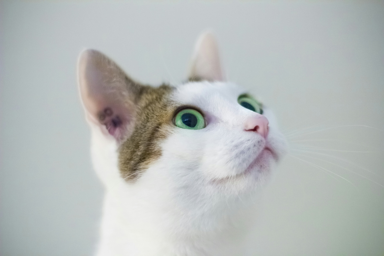

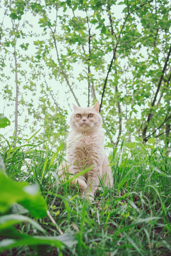

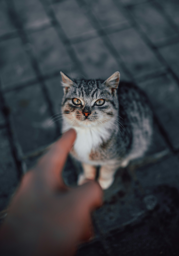

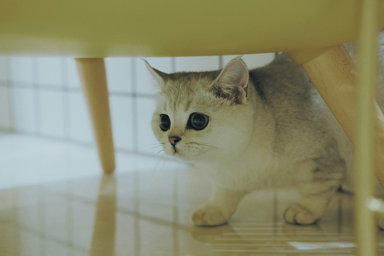

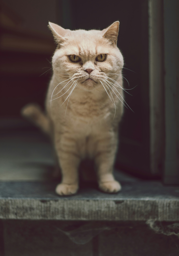

In [57]:
indices, values = get_similar_images(img_features, "猫", k=5)